In [6]:
# importing required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

In [8]:
# reading the pizza sales dataset
sales = pd.read_csv(r"D:\GUVICourse\Capstone5\Pizza_Sale - pizza_sales.csv")
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [9]:
sales.shape

(48620, 12)

In [10]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [11]:
# converting order date and time to datetime fromat
sales['order_date'] = pd.to_datetime(sales['order_date'], format='mixed')
sales['order_time'] = pd.to_datetime(sales['order_time'], format='%H:%M:%S').dt.time
sales.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [12]:
# Checking null values 
sales.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [13]:
# dropping null values
sales.dropna(inplace=True)

In [14]:
sales.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [16]:
# Checking duplicates
sales.duplicated().sum()

np.int64(0)

In [17]:
# checking orderdate type
sales['order_date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: order_date, dtype: datetime64[ns]

In [18]:
sales.describe()


,pizza_id,order_id,quantity,order_date,unit_price,total_price
count,48554.000000,48554.000000,48554.000000,48554,48554.000000,48554.000000
mean,24342.866458,10715.733081,1.019648,2015-06-29 00:59:45.616015104,16.493957,16.821744
min,1.000000,1.000000,1.000000,2015-01-01 00:00:00,9.750000,9.750000
25%,12205.250000,5360.250000,1.000000,2015-03-30 00:00:00,12.750000,12.750000
50%,24343.500000,10702.000000,1.000000,2015-06-28 00:00:00,16.500000,16.500000
75%,36481.750000,16107.750000,1.000000,2015-09-29 00:00:00,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,2015-12-31 00:00:00,35.950000,83.000000
std,14017.563232,6172.205962,0.143172,NaN,3.621876,4.438471


In [19]:
# Checking unique values in each column
sales.nunique()

pizza_id             48554
order_id             21326
pizza_name_id           91
quantity                 4
order_date             358
order_time           16368
unit_price              25
total_price             56
pizza_size               5
pizza_category           4
pizza_ingredients       32
pizza_name              32
dtype: int64

Exploratory Data Analysis (EDA)

Daily sales trend over time

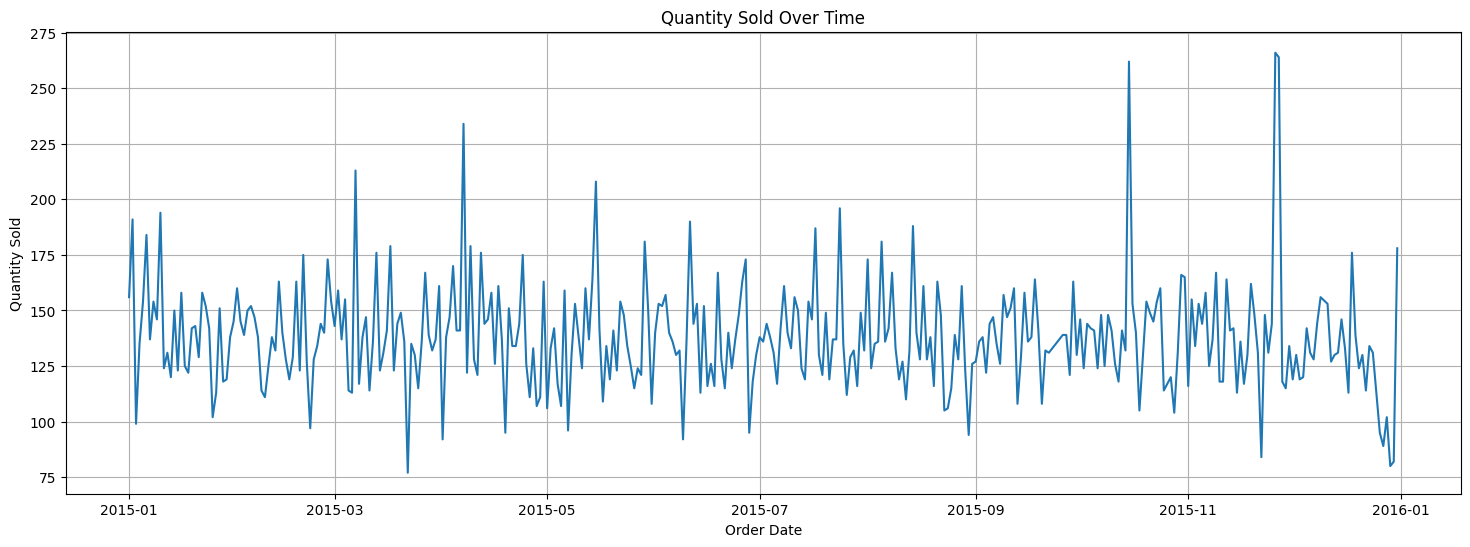

In [20]:
daily_sales = sales.groupby('order_date').agg({'quantity': 'sum'})

# Create the plot
plt.figure(figsize=(18, 6))
plt.plot(daily_sales.index, daily_sales.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.grid(True)
plt.show()

Top Selling Pizzas

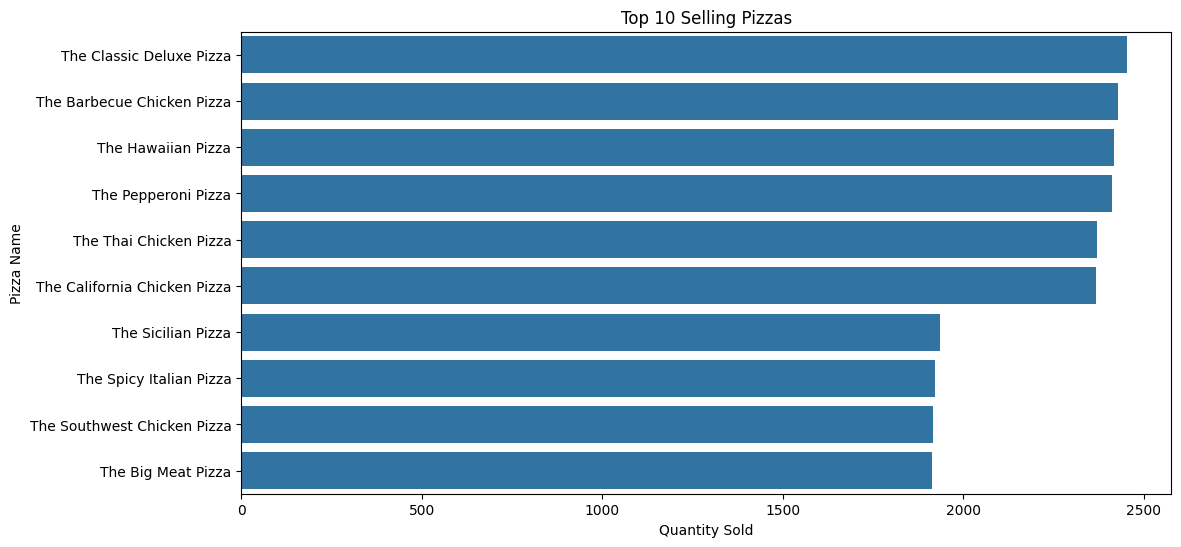

In [21]:
# Group by pizza and calculate total sales
top_pizzas = sales.groupby('pizza_name').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)

# Plot top-selling pizzas
plt.figure(figsize=(12, 6))
sns.barplot(x=top_pizzas['quantity'].head(10), y=top_pizzas.head(10).index)
plt.title('Top 10 Selling Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

Sales by day of week

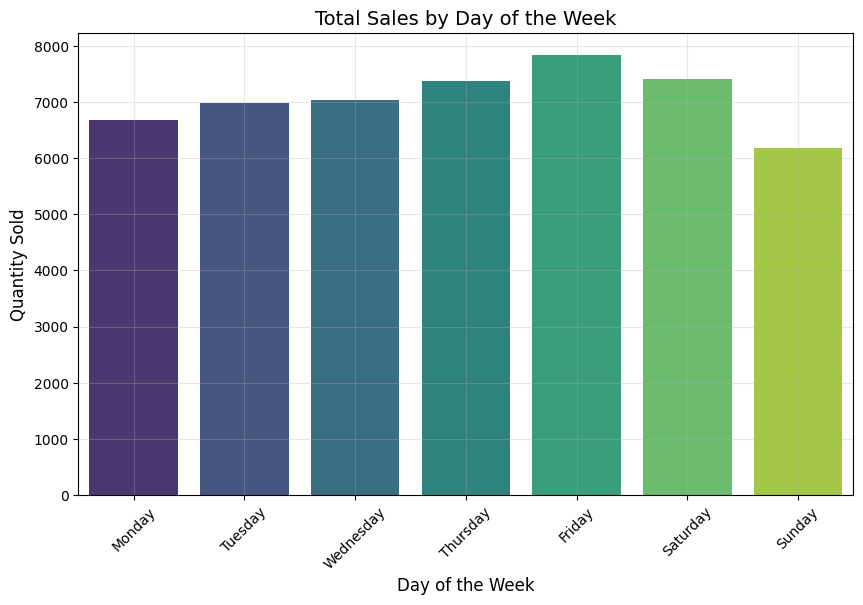

In [22]:
# Add a day of the week column
sales['day_of_week'] = sales['order_date'].dt.day_name()

# Group by day of the week
sales_by_day = sales.groupby('day_of_week').agg({'quantity': 'sum'}).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plot sales by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_day.index, y=sales_by_day['quantity'], palette="viridis")
plt.title('Total Sales by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

Sales By Month

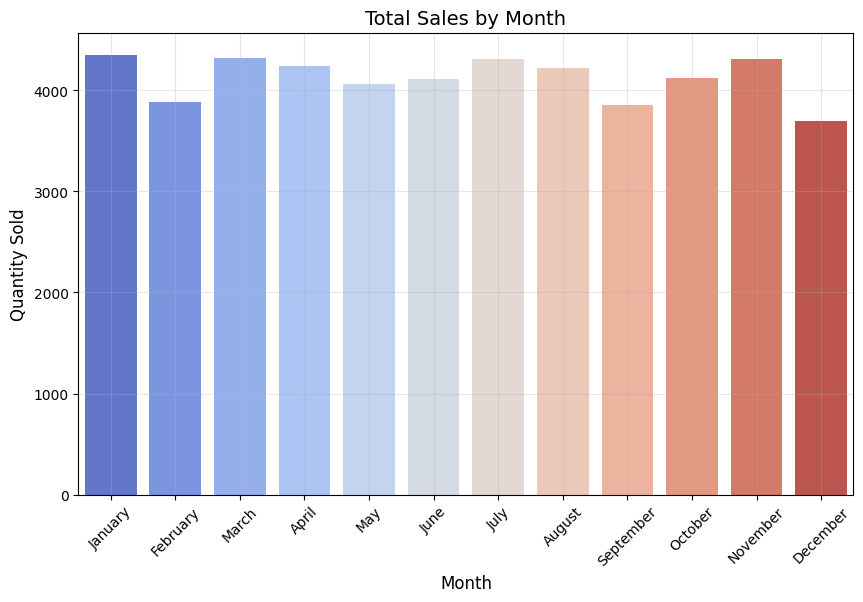

In [23]:
# Add a month column
sales['month'] = sales['order_date'].dt.month_name()

# Group by month
sales_by_month = sales.groupby('month').agg({'quantity': 'sum'}).reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 
     'July', 'August', 'September', 'October', 'November', 'December']
)

# Plot sales by month
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_month.index, y=sales_by_month['quantity'], palette="coolwarm")
plt.title('Total Sales by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

Peak selling hours in a day

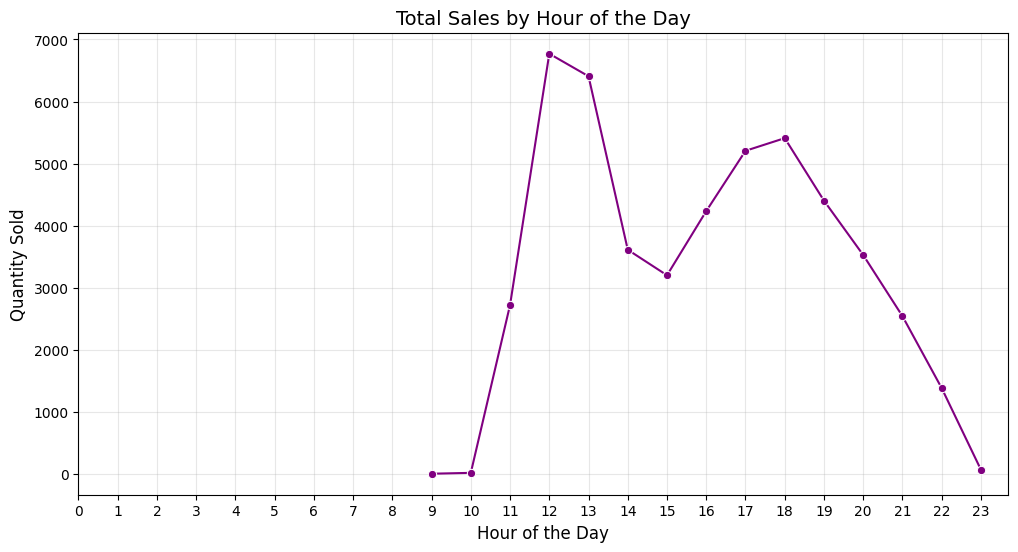

In [24]:
# Extract hour from order time
sales['hour'] = pd.to_datetime(sales['order_time'], format='%H:%M:%S').dt.hour

# Group by hour
sales_by_hour = sales.groupby('hour').agg({'quantity': 'sum'})

# Plot sales by hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=sales_by_hour.index, y=sales_by_hour['quantity'], marker='o', linestyle='-', color='purple')
plt.title('Total Sales by Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(range(0, 24))
plt.show()

Checking Outliers

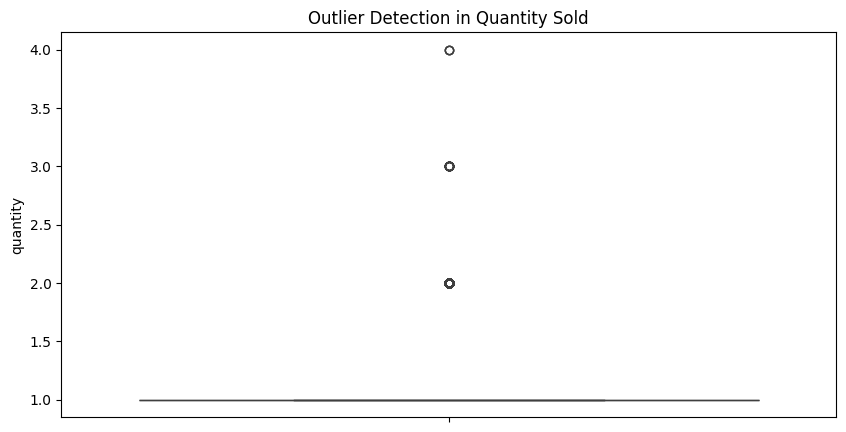

In [25]:
# Plot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(sales['quantity'])
plt.title('Outlier Detection in Quantity Sold')
plt.show()

In [26]:
# Remove extreme outliers if necessary
sales = sales[sales['quantity'] < sales['quantity'].quantile(0.99)]

The 99th percentile typically excludes the top 1% of values, which are often extreme outliers in large dataset

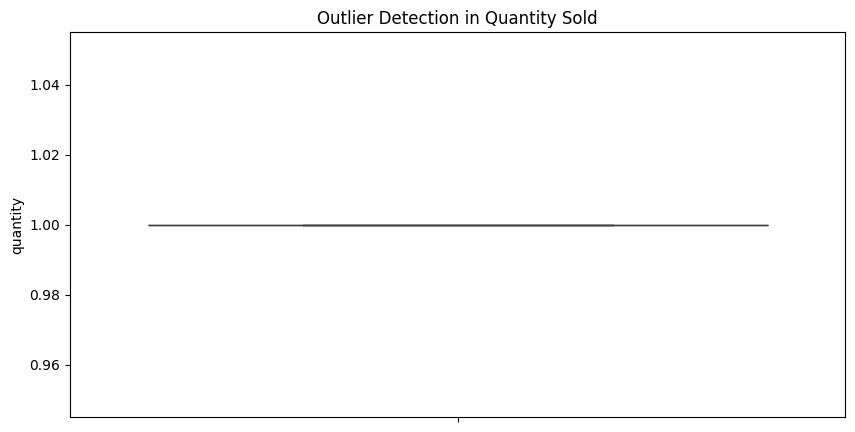

In [27]:
# Plot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(sales['quantity'])
plt.title('Outlier Detection in Quantity Sold')
plt.show()

Stationarity Check

In [28]:
# Using  Augmented Dickey-Fuller test to check stationarity

# H0: it is not stationary
# H1: it is stationary

def adf_test(sales):
  result = adfuller(sales)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')

In [29]:
adf_test(daily_sales)

ADF Statistic: -4.919389
p-value: 0.000032
# Lags used: 15
No of observations used: 342
we reject the null hypothesis, The series is stationary


Check Stationarity:

Used the Augmented Dickey-Fuller (ADF) test to determine if the series is stationary. A stationary series has constant mean and variance over time. If the p-value from the test is above 0.05, the series is not stationary, and differencing is required.

Autocorrelation and partial Autocorrelation

Autocorrelation Function (ACF):

The ACF plot shows the correlation of the series with its lags. Use the ACF to identify q (the number of lagged forecast errors in the ARIMA model). Look for the point where the ACF plot cuts off (significant lags end abruptly).

Partial Autocorrelation Function (PACF):

The PACF plot shows the correlation of the series with its lags after removing the effects of intermediate lags. Use the PACF to identify p (the number of lagged terms in the ARIMA model). Look for the point where the PACF plot cuts off

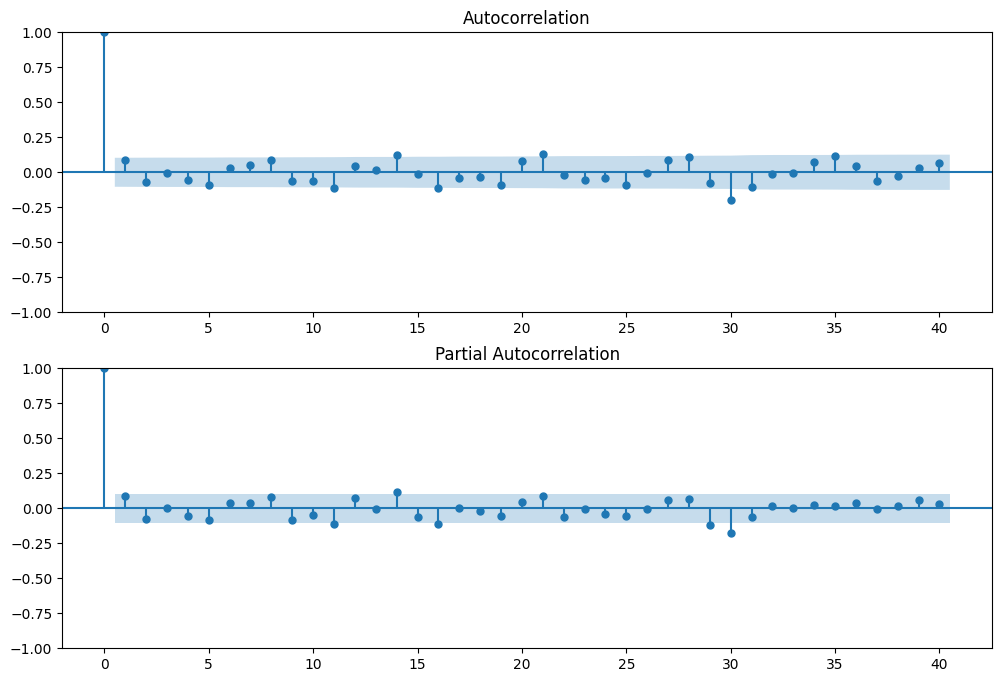

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

# Acf plot
fig = plot_acf(daily_sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)

# pacf plot 
fig = plot_pacf(daily_sales, lags=40, ax=ax2)

ACF Plot:

The ACF cuts off sharply after lag 2, indicating that the moving average component q=2. PACF Plot:

The PACF cuts off sharply after lag 1, indicating that the autoregressive component p=1.

Sales Prediction

In [31]:
# Predicting sales of pizzas for next 7  days using ARIMA, SARIMA, Prophet, LSTM 
# choosing best model base on MAPE score(mean_absolute_percentage_error)
data = sales.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)
data.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,12.0,5.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,3.0,0.0,5.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,4.0,6.0,1.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,3.0,9.0,4.0,4.0,...,5.0,5.0,0.0,6.0,5.0,2.0,4.0,5.0,10.0,6.0


In [32]:
one_pizza = data['The Barbecue Chicken Pizza']

In [33]:
# Train-Test Split
train = one_pizza[:-30]  # Use all but the last 30 days for training
test = one_pizza[-30:]   # Use the last 30 days for testing

In [34]:
train.isna().sum()

np.int64(0)

In [35]:
train = train.fillna(train.median())

ARIMA Model

In [36]:
print(train.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23',
               '2015-11-24', '2015-11-25', '2015-11-26', '2015-11-27',
               '2015-11-28', '2015-11-29'],
              dtype='datetime64[ns]', name='order_date', length=328, freq=None)


In [37]:
train.index = pd.to_datetime(train.index)
train = train.asfreq('D')  # 'D' for daily, adjust based on your data's frequency

In [38]:
# Fit ARIMA model (order=(1, 1, 1) as a starting point; optimize based on AIC/BIC)
arima_model = ARIMA(train, order=(1, 0, 2))
arima_result = arima_model.fit()

# Forecast
arima_forecast = arima_result.forecast(steps=len(test))

# Evaluate ARIMA Model
arima_mape = mean_absolute_percentage_error(test, arima_forecast)

print("ARIMA Model MAPE:", arima_mape)

ARIMA Model MAPE: 0.49021344525549904


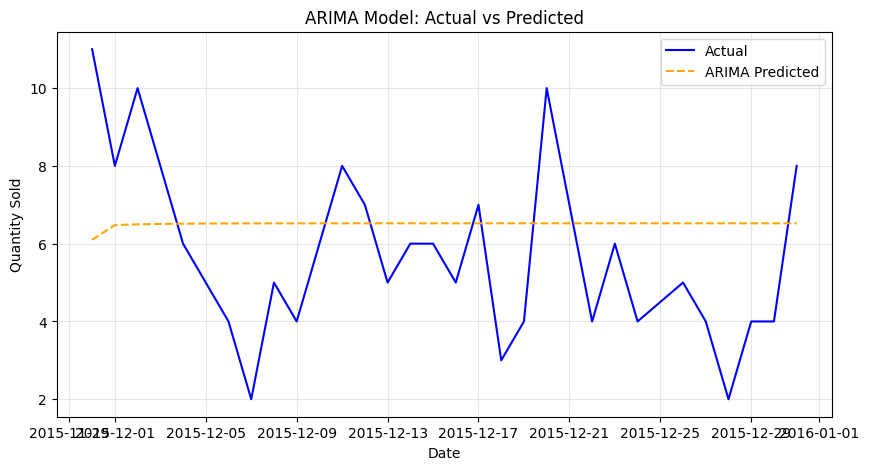

In [39]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Predicted', linestyle='--', color='orange')
plt.title('ARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

ARIMA model is appearing to predict a flat trend, not capturing the variability in actual sales

SARIMA Model

In [40]:
# Fit SARIMA model (seasonal_order=(1, 1, 1, 7) for weekly seasonality; adjust as needed)
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()

# Forecast
sarima_forecast = sarima_result.forecast(steps=len(test))

# Evaluate SARIMA Model
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast)

print("SARIMA Model MAPE:", sarima_mape)

SARIMA Model MAPE: 0.4439559464407632


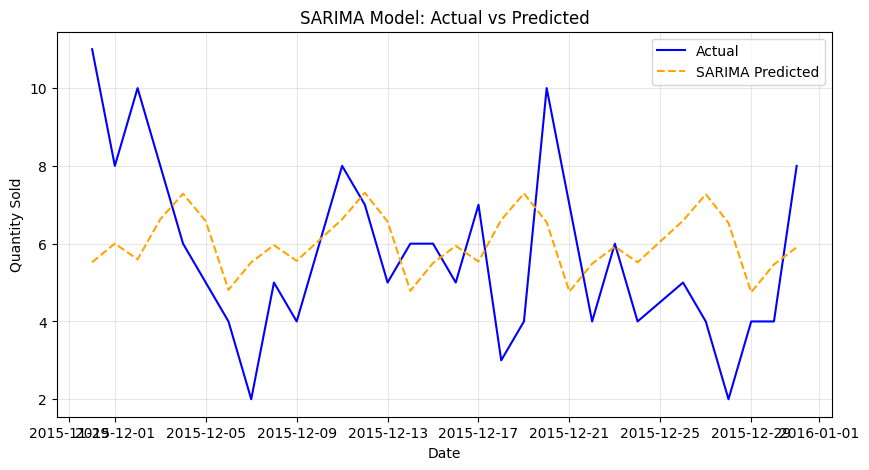

In [41]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, sarima_forecast, label='SARIMA Predicted', linestyle='--', color='orange')
plt.title('SARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

SARIMA predictions show periodic peaks and dips, indicating it captures seasonality better than ARIMA.

However, there’s still a lag in capturing sudden changes in sales

Prophet Model

In [44]:
from prophet import Prophet

In [43]:
# Prepare data for Prophet
prophet_data = one_pizza.reset_index()
prophet_data.columns = ['ds', 'y']

# Train-Test Split
prophet_train = prophet_data[:-30]
prophet_test = prophet_data[-30:]

# Fit Prophet Model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Forecast
future_dates = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future_dates)

# Extract only test period forecast
prophet_test_forecast = prophet_forecast[-30:]['yhat']

# Evaluate Prophet Model
prophet_mape = mean_absolute_percentage_error(prophet_test['y'], prophet_test_forecast)

print("Prophet Model MAPE:", prophet_mape)

12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model MAPE: 0.43721742414577064


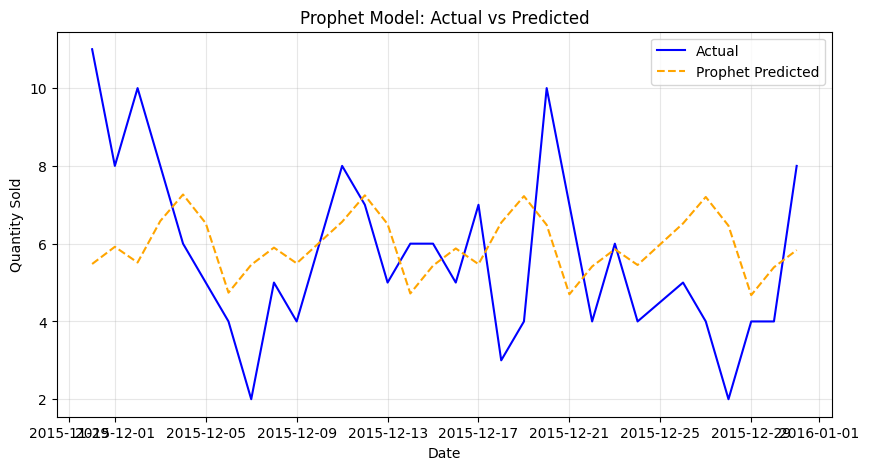

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue')
plt.plot(prophet_test['ds'], prophet_test_forecast, label='Prophet Predicted', linestyle='--', color='orange')
plt.title('Prophet Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Prophet captures seasonal variations well, closely following the periodic fluctuations of actual sales.

Some deviations are present during sharp changes, but overall, Prophet performs robustly

In [46]:
print(f"ARIMA Model MAPE: {arima_mape}")
print(f"SARIMA Model MAPE: {sarima_mape}")
print(f"Prophet Model MAPE: {prophet_mape}")

ARIMA Model MAPE: 0.49021344525549904
SARIMA Model MAPE: 0.4439559464407632
Prophet Model MAPE: 0.43721742414577064


Based on the provided MAPE (Mean Absolute Percentage Error) values, Prophet has the lowest MAPE, making it the best-performing model for our dataset. Prophet is handling seasonality and trends effectively.

Sales Forecasting: Predicting pizza sales for the next one week using the trained Prophet model.

In [51]:
# Initialize dictionary to store forecasts
all_forecasts = {}

# Loop through each pizza type
for pizza in data.columns:  # data contains daily sales of each pizza
    one_pizza_sales = data[pizza].reset_index()
    one_pizza_sales.columns = ['ds', 'y']  # Prophet requires columns ['ds', 'y']
    
    # Create a new Prophet model instance for each pizza
    prophet_model = Prophet()
    
    # Fit the model to the data
    prophet_model.fit(one_pizza_sales)

    # Forecast for the next 7 days
    future_dates = prophet_model.make_future_dataframe(periods=7)  # Corrected here
    forecast = prophet_model.predict(future_dates)
    
    # Store forecasted values (last 7 days)
    all_forecasts[pizza] = forecast.iloc[-7:]['yhat'].values

# Convert forecasts into a DataFrame
forecast_df = pd.DataFrame(all_forecasts)
forecast_df.index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7)

forecast_df

12:57:12 - cmdstanpy - INFO - Chain [1] start processing
12:57:12 - cmdstanpy - INFO - Chain [1] done processing
12:57:13 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing
12:57:13 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing
12:57:13 - cmdstanpy - INFO - Chain [1] start processing
12:57:13 - cmdstanpy - INFO - Chain [1] done processing
12:57:14 - cmdstanpy - INFO - Chain [1] start processing
12:57:14 - cmdstanpy - INFO - Chain [1] done processing
12:57:14 - cmdstanpy - INFO - Chain [1] start processing
12:57:14 - cmdstanpy - INFO - Chain [1] done processing
12:57:14 - cmdstanpy - INFO - Chain [1] start processing
12:57:15 - cmdstanpy - INFO - Chain [1] done processing
12:57:15 - cmdstanpy - INFO - Chain [1] start processing
12:57:15 - cmdstanpy - INFO - Chain [1] done processing
12:57:15 - cmdstanpy - INFO - Chain [1] start processing
12:57:15 - cmdstanpy - INFO - Chain [1]

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,7.037887,4.951689,1.484724,2.830294,6.831083,3.357052,3.193108,7.653488,3.986496,5.642348,...,4.644131,5.994641,2.857282,5.799839,5.562450,3.406533,2.942635,4.571400,6.730517,4.380344
2016-01-02,6.299159,5.029011,1.217387,2.839404,5.812976,2.940253,2.469717,7.072362,2.943251,5.579987,...,3.735435,5.996070,2.553831,4.977142,5.325831,2.739437,2.346077,3.470703,6.413686,4.366876
2016-01-03,4.700721,4.364114,1.511222,2.281558,5.035795,2.155344,2.500520,5.772282,2.775812,4.391448,...,3.612774,4.347425,2.135823,4.232634,4.235159,2.497879,2.006320,3.366429,5.481311,3.768260
2016-01-04,5.347371,4.651227,1.443492,3.089176,5.952823,2.757588,2.771182,6.811251,3.027536,4.721162,...,3.664551,4.354531,2.137526,5.258796,4.718965,2.448607,2.183903,3.952011,6.850571,3.962795
2016-01-05,5.724242,4.316668,1.583450,2.743206,5.332053,2.498318,2.004957,6.938037,3.580693,4.733678,...,4.216435,4.784415,3.034418,5.073097,5.033692,2.720300,2.211541,3.355198,6.144613,3.542593
2016-01-06,5.398943,4.605382,1.602660,2.897066,5.639627,2.536871,2.762721,6.591040,3.118050,5.271875,...,3.754961,5.399885,2.572811,4.764955,4.994057,2.432316,2.250036,3.835985,5.971623,4.293518
2016-01-07,6.447150,5.008372,1.737835,2.841662,5.995109,2.742665,2.953441,6.939367,3.522507,5.732380,...,3.749406,5.369175,2.601518,5.406941,5.584862,2.637955,2.464121,4.005361,6.519852,4.510614


In [64]:
# Round the forecasted number of pizzas to the nearest whole number
forecast_df = forecast_df.round()

# Display the updated forecast DataFrame
forecast_df

,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2016-01-01,7.0,5.0,1.0,3.0,7.0,3.0,3.0,8.0,4.0,6.0,...,5.0,6.0,3.0,6.0,6.0,3.0,3.0,5.0,7.0,4.0
2016-01-02,6.0,5.0,1.0,3.0,6.0,3.0,2.0,7.0,3.0,6.0,...,4.0,6.0,3.0,5.0,5.0,3.0,2.0,3.0,6.0,4.0
2016-01-03,5.0,4.0,2.0,2.0,5.0,2.0,3.0,6.0,3.0,4.0,...,4.0,4.0,2.0,4.0,4.0,2.0,2.0,3.0,5.0,4.0
2016-01-04,5.0,5.0,1.0,3.0,6.0,3.0,3.0,7.0,3.0,5.0,...,4.0,4.0,2.0,5.0,5.0,2.0,2.0,4.0,7.0,4.0
2016-01-05,6.0,4.0,2.0,3.0,5.0,2.0,2.0,7.0,4.0,5.0,...,4.0,5.0,3.0,5.0,5.0,3.0,2.0,3.0,6.0,4.0
2016-01-06,5.0,5.0,2.0,3.0,6.0,3.0,3.0,7.0,3.0,5.0,...,4.0,5.0,3.0,5.0,5.0,2.0,2.0,4.0,6.0,4.0
2016-01-07,6.0,5.0,2.0,3.0,6.0,3.0,3.0,7.0,4.0,6.0,...,4.0,5.0,3.0,5.0,6.0,3.0,2.0,4.0,7.0,5.0


In [67]:
# Export the DataFrame to a CSV file named 'forecast_next_week.csv'
forecast_df.to_csv(r'D:\GUVICourse\Capstone5\forecast_next_week.csv', index=False)

Ingredient Calculation

In [53]:
ingredients = pd.read_csv(r'D:\GUVICourse\Capstone5\Pizza_ingredients - Pizza_ingredients.csv')
ingredients.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [54]:
ingredients.nunique()

pizza_name_id         91
pizza_name            32
pizza_ingredients     64
Items_Qty_In_Grams    17
dtype: int64

In [58]:
ingredient_forecast = []

# Loop through each pizza in forecast_df
for pizza in forecast_df.columns:
    # Get the total forecasted sales for the pizza (sum across 7 days)
    total_sales = forecast_df[pizza].sum()

    # Get the ingredient requirements for the pizza from ingredients_data
    pizza_ingredients = ingredients[ingredients['pizza_name'] == pizza]
    
    # Calculate total ingredient requirements
    for _, row in pizza_ingredients.iterrows():
        ingredient_forecast.append({
            'ingredient': row['pizza_ingredients'],  # Ingredient name
            'quantity_needed': total_sales * row['Items_Qty_In_Grams']  # Forecast * quantity per pizza
        })

# Convert to DataFrame
ingredient_forecast_df = pd.DataFrame(ingredient_forecast)

# Summarize by ingredient
final_purchase_order = ingredient_forecast_df.groupby('ingredient').agg({'quantity_needed': 'sum'}).reset_index()

# Add a unit column (e.g., grams)
final_purchase_order['unit'] = 'grams'

# Export the DataFrame to a CSV file named 'final_Purchase_order.csv'
final_purchase_order.to_csv(r'D:\GUVICourse\Capstone5\final_Purchase_order.csv', index=False)

# Display the final purchase order
print("Final Purchase Order:")
final_purchase_order

Final Purchase Order:


,ingredient,quantity_needed,unit
0,?duja Salami,2400.0,grams
1,Alfredo Sauce,855.0,grams
2,Anchovies,2295.0,grams
3,Artichokes,6705.0,grams
4,Arugula,870.0,grams
...,...,...,...
59,Sun-dried Tomatoes,1140.0,grams
60,Thai Sweet Chilli Sauce,2640.0,grams
61,Thyme,55.0,grams
62,Tomatoes,32400.0,grams
